# Creación de un GPT Privado con OpenAI y LangChain

En el artículo [Como crear tu ChatGPT privado](https://www.pgconocimiento.com/como-crear-tu-chatgpt-privado/) puedes encontrar una explicación detallada del contenido de este notebook.

## Configuración

Iniciamos la ejecución recuperando la clave API de OpenAI desde el archivo de entorno. Se puede obtener una clave API desde la [web de OpenAI](https://platform.openai.com/playground)

In [1]:
import os
import openai
import sys
sys.path.append('../..')

from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv()) # Leemos el fichero local .env

# Recuperación de las variables de entorno
openai.vapi_key  = os.environ['OPENAI_API_KEY']


## Ingesta
### Carga de documentos

Para nuestro ejemplo, cargaremos el documento "Creación de Chatbots con IA.pdf" 

In [3]:
from langchain.document_loaders import PyPDFLoader
document = os.environ['DOCUMENT']      # docs/Creacion-de-chatbots-con-IA.pdf

loader = PyPDFLoader(document)
pages = loader.load()

Una vez cargado, cada página es un `Document`. Un `Document` contiene texto (`page_content`) y `metadata`.

In [4]:
print("Número de páginas del documento: ", len(pages))
page = pages[0]
print("Número de caracteres de la página: ", len(page.page_content))
print("Metadata: ", page.metadata)
print("Extracto del Contenido:" , page.page_content[0:1000])


Número de páginas del documento:  7
Número de caracteres de la página:  3275
Metadata:  {'source': 'docs/Creacion-de-chatbots-con-IA.pdf', 'page': 0}
Extracto del Contenido:            
      
LLM e Inteligencia Artificial Generativa La irrupción de ChatGPT dentro de la categoría de Inteligencia Artificial Generativa basada en LLM y su habilidad para responder a cualquier tipo de pregunta abre una nueva vía en el desarrollo de chatbots para la atención de clientes y usuarios. Este artículo explica los conceptos fundamentales de esta nueva tecnología que algunos expertos sitúan a nivel disruptivo a la altura de la aparición de Internet. ¿Que es LLM e Inteligencia Artificial Generativa? Los Modelos de Lenguaje de Gran Escala(LLM) son un tipo de inteligencia artificial (IA) que ha revolucionado la forma en que las máquinas comprenden y generan texto de manera natural. Un ejemplo destacado de LLM es GPT (Generative Pre-trained Transformer) desarrollado por OpenAI. Estos modelos, como GPT, 

### Transformación

Definimos los parámetros de la segmentación del texto y utilizamos `RecursiveCharacterTextSplitter` porque es mejor para carga de texto

In [5]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
chunk_size = int(os.environ['CHUNK'])      # 1000
chunk_overlap = int(os.environ['OVERLAP']) # 100

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=chunk_size,
    chunk_overlap=chunk_overlap,
    separators=["\n\n", "\n", "(?<=\. )", " ", ""]
)

# Ejecutamos la segmentación de documentos
splitted_pages = text_splitter.split_documents(pages)


Una vez segmentados los documentos validamos que la segmentacion se ha ha realizado correctamente

In [6]:
print("Número de segmentos: ", len(splitted_pages))
print("***")      
for i in range(4):
    print("Tamaño del segmento: ",len(splitted_pages[i].page_content))
    print("Metadata: ", splitted_pages[i].metadata)
    print("Contenido:" , splitted_pages[i].page_content)
    print("-----------------------------------------------")

Número de segmentos:  21
***
Tamaño del segmento:  994
Metadata:  {'source': 'docs/Creacion-de-chatbots-con-IA.pdf', 'page': 0}
Contenido: LLM e Inteligencia Artificial Generativa La irrupción de ChatGPT dentro de la categoría de Inteligencia Artificial Generativa basada en LLM y su habilidad para responder a cualquier tipo de pregunta abre una nueva vía en el desarrollo de chatbots para la atención de clientes y usuarios. Este artículo explica los conceptos fundamentales de esta nueva tecnología que algunos expertos sitúan a nivel disruptivo a la altura de la aparición de Internet. ¿Que es LLM e Inteligencia Artificial Generativa? Los Modelos de Lenguaje de Gran Escala(LLM) son un tipo de inteligencia artificial (IA) que ha revolucionado la forma en que las máquinas comprenden y generan texto de manera natural. Un ejemplo destacado de LLM es GPT (Generative Pre-trained Transformer) desarrollado por OpenAI. Estos modelos, como GPT, son entrenados en grandes conjuntos de datos para apre

### Embeddings

Una vez que hemos dividido los documentos en segmentos, llega el momento de convertirlos en vectores numéricos que se almacenarán en una base de datos de Vectores (Storage - VectorStorage)


In [7]:
from langchain.embeddings.openai import OpenAIEmbeddings
from langchain.vectorstores import Chroma

persist_directory=os.environ['PERSIST_DIRECTORY']

!rm -rf $PERSIST_DIRECTORY  # borramos lo que hubiera en la base de datos

Definimos el formato de Embeddings que utilizaremos que debe coincidir con el modelo de Embeddings que utilizará el LLM para generar la respuesta (en nuestro caso será ***OpenAIEmbeddings***), y generamos la base de datos vetorial indicando los elementos a codificar, el modelo de embeddings y el directorio donde guardar los datos. 

Finalmente validamos que el tamaño del vector generado coincide con el tamaño de los segmentos de página que debemos cargar y persistimos la base de datos en disco

In [8]:
# Definir el modelo de embbeddings
embedding = OpenAIEmbeddings()

# Generamos el vector codificado de los documentos a cargar
vectordb = Chroma.from_documents(
    documents=splitted_pages,
    embedding=embedding,
    persist_directory=persist_directory
)

# Validamos el número de vectores creados (debe coincidir con el número de segmentos de páginas a cargar)
print(vectordb._collection.count())

# Persistimos el vector
vectordb.persist()

Using embedded DuckDB with persistence: data will be stored in: db/docsdb
No embedding_function provided, using default embedding function: SentenceTransformerEmbeddingFunction
/home/administrador/.conda/envs/gptprivado/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


21


## Generación de la respuesta


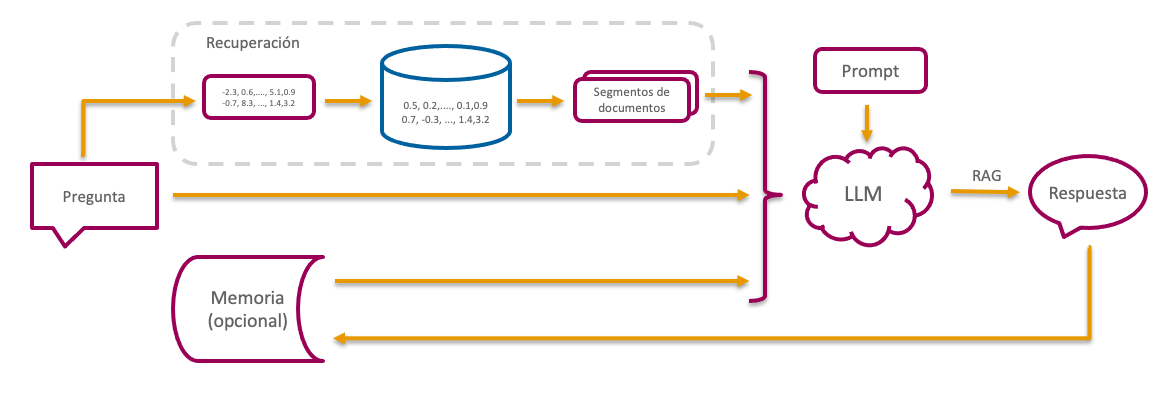

#### Recuperación
Para validar que funciona correctamente la base de datos vectorial con las codificaciones del documento que hemos cargado, realizaremos búsquedas por similitud con el método ```similarity_search``` pasando como parámetros la pregunta y el número de segmentos que queremos que retorne.

In [9]:
# Definimos una lista de preguntas
questions = [
    "¿Qué és LLM?",
    "¿Qué es SapiensXBot?",
    "Cuáles son las ventajas de usar modelos de lenguaje GPT en la creación de chatbots?",
    "¿y las desventajas?"
]

# Buscamos la respuesta a cada pregunta
for question in questions:
    answers = vectordb.similarity_search(question,k=3)  # k es el número de segmentos encontrados, por defecto = 4
    print(question)
    print(len(answers))
    
    for answer in answers:
        # para cada pregunta inprimimos las respuestas generadas
        print(answer.metadata)
        print(answer)
        print("-------")
    print("****************************************")

¿Qué és LLM?
3
{'source': 'docs/Creacion-de-chatbots-con-IA.pdf', 'page': 0}
page_content='LLM e Inteligencia Artificial Generativa La irrupción de ChatGPT dentro de la categoría de Inteligencia Artificial Generativa basada en LLM y su habilidad para responder a cualquier tipo de pregunta abre una nueva vía en el desarrollo de chatbots para la atención de clientes y usuarios. Este artículo explica los conceptos fundamentales de esta nueva tecnología que algunos expertos sitúan a nivel disruptivo a la altura de la aparición de Internet. ¿Que es LLM e Inteligencia Artificial Generativa? Los Modelos de Lenguaje de Gran Escala(LLM) son un tipo de inteligencia artificial (IA) que ha revolucionado la forma en que las máquinas comprenden y generan texto de manera natural. Un ejemplo destacado de LLM es GPT (Generative Pre-trained Transformer) desarrollado por OpenAI. Estos modelos, como GPT, son entrenados en grandes conjuntos de datos para aprender patrones y contextos del lenguaje natural. 

### Definición del Prompt

In [10]:
from langchain.prompts import PromptTemplate

# Build prompt
template = """Use the following pieces of context to answer the question at the end. 
        If you don't know the answer, just say that you don't know the answer, don't 
        try to make up an answer. Use three sentences maximum. Keep the answer as concise 
        as possible. Always say "Gracias por preguntar" at the end of the answer. 
{context}
Question: {question}
Helpful Answer:"""
QA_CHAIN_PROMPT = PromptTemplate.from_template(template)

### Generación de la respuesta
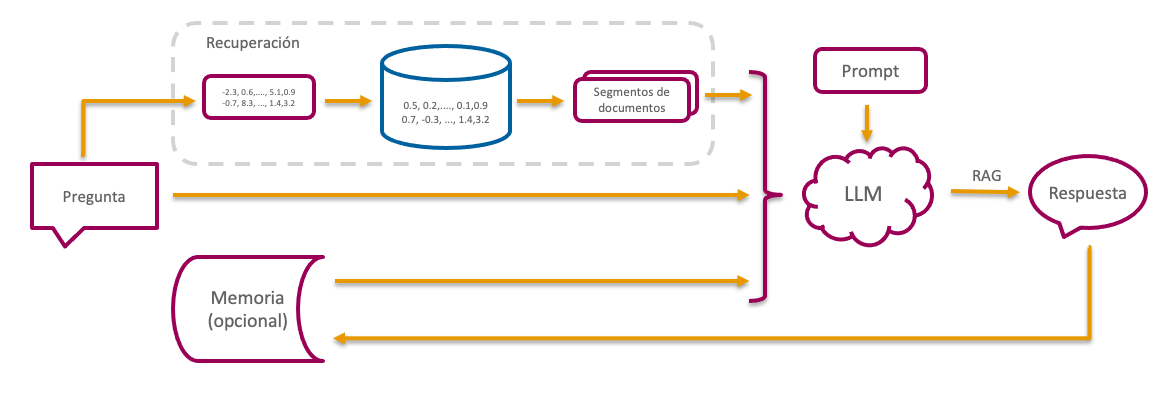

In [11]:
from langchain.chat_models import ChatOpenAI
llm = ChatOpenAI(model_name="gpt-3.5-turbo", temperature=0)
from langchain.chains import RetrievalQA

chain_types=["stuff", "map_reduce", "refine", "map_rerank"]
mychain_type= "stuff"
# pruebas con pregunta 1 de trámites
# stuff: admite prompt 4 seg 
# map_reduce: no admite prompt, 29 segons i respon en castellà
# refine no admite prompt : 1 min 30 segons 
# map_rerank: no admite prompt : 15 segons 
qa_chain = RetrievalQA.from_chain_type(
    llm,
    retriever=vectordb.as_retriever(),
    return_source_documents=True,
    chain_type=mychain_type,
    chain_type_kwargs={"prompt": QA_CHAIN_PROMPT}
)


#### Realizamos las preguntas
La respuesta viene en una estructura que contiene además de la respuesta propiamente dicha, la pregunta y los segmentos de documentos recogidos de la base de datos junto con sus metadatos

In [26]:
for question in questions:
    result = qa_chain({"query": question})
    print(result["query"])
    print(result["result"])
    print('-----------')

¿Qué és LLM?
LLM son las siglas de "Modelos de Lenguaje de Gran Escala", que son un tipo de inteligencia artificial que ha revolucionado la forma en que las máquinas comprenden y generan texto de manera natural. Gracias por preguntar.
-----------
¿Qué es SapiensXBot?
SapiensXBot es un chatbot que utiliza inteligencia artificial para interpretar las frases recibidas por parte del usuario y detectar la intención con un porcentaje de confianza. Gracias por preguntar.
-----------
Cuáles son las ventajas de usar modelos de lenguaje GPT en la creación de chatbots?
Las ventajas de usar modelos de lenguaje GPT en la creación de chatbots son la comprensión del lenguaje natural, la capacidad de aprendizaje y la capacidad de generar respuestas en contextos complejos sin necesidad de un entrenamiento específico. Gracias por preguntar.
-----------
¿y las desventajas?
No se mencionan las desventajas en el texto proporcionado. Gracias por preguntar.
-----------


Podemos ver los segmentos de documentos que generaron la respuesta y sus metadatos

In [16]:
for source in result["source_documents"]:
    print(source.metadata)
    print(source.page_content)
    print("----")

{'source': 'docs/Creacion-de-chatbots-con-IA.pdf', 'page': 1}
proyectos no es trivial y, como todo, tiene sus ventajas e inconvenientes que comentamos en nuestro artículo Chatbots con Plataformas NLP vs. Modelos de Lenguaje GPT.
----
{'source': 'docs/Creacion-de-chatbots-con-IA.pdf', 'page': 2}
proyectos. Multi-idioma Los modelos más potentes (a partir de decenas de miles de millones de parámetros 13B y superiores) están entrenados en varios idiomas por lo que son capaces de comprender la pregunta independientemente del idioma en que se ha realizado y responder en el mismo idioma. Escalabilidad La escalabilidad viene determinada por el uso de una API pública para realizar las preguntas. Esto nos permite utilizar los modelos sin necesidad de tener que proveer una infraestructura compleja y cara que necesitará de ordenadores con varias GPUs. Desventajas Potenciales errores Uno de los principales problemas de los models LLM son las llamadas «Alucinaciones». Como su propio nombre indica, l

In [17]:
result = qa_chain({"query": 'cuales son las desventajas de utilizar modelos de lenjuaje GPT en la construcción de chatbots?'})
print(result["query"])
print(result["result"])

cuales son las desventajas de utilizar modelos de lenjuaje GPT en la construcción de chatbots?
Las desventajas de utilizar modelos de lenguaje GPT en la construcción de chatbots son las alucinaciones, ya que pueden generar respuestas incoherentes o incorrectas, y la necesidad de un gran volumen de datos para entrenar el modelo correctamente. Gracias por preguntar.


## Chat

Las respuestas proporcionadas hasta ahora son independientes de las preguntas realizadas anteriormente. Para que las respuestas tengan en consideración las preguntas anteriores, debemos proporcionar memoria a las conversaciones.

### Memoria

Definimos el objeto memoria que guardará la conversación y se pasará como parámmetro a la cadena de generación de la respuesta

In [27]:
from langchain.memory import ConversationBufferMemory
memory = ConversationBufferMemory(
    memory_key="chat_history",
    return_messages=True,
    input_key='question', 
    output_key='answer'
)

### ConversationalRetrievalChain

In [28]:
from langchain.chains import ConversationalRetrievalChain
qa = ConversationalRetrievalChain.from_llm(
    llm,
    retriever=vectordb.as_retriever(),
    memory=memory
)

In [29]:
for pregunta in questions[-2:]:
    result = qa({"question": pregunta})
    print(pregunta)
    print(result['answer'])
    print('------')

Cuáles son las ventajas de usar modelos de lenguaje GPT en la creación de chatbots?
Las ventajas de usar modelos de lenguaje GPT en la creación de chatbots son:

1. Comprensión del lenguaje natural: Los modelos de lenguaje GPT están entrenados con una gran cantidad de parámetros, lo que les permite entender y generar texto en contextos complejos sin necesidad de un entrenamiento específico para situaciones concretas.

2. Capacidad de aprendizaje: Continuamente están apareciendo modelos nuevos y mejorados que se pueden incorporar fácilmente a los proyectos de chatbots con pocos cambios.

3. Multi-idioma: Los modelos más potentes de lenguaje GPT tienen la capacidad de comprender y generar texto en varios idiomas, lo que permite desarrollar chatbots multilingües.

4. Facilidad de uso: Los modelos de lenguaje GPT facilitan la tarea de entender y generar respuestas en lenguaje natural sin necesidad de un gran esfuerzo, ya que han sido entrenados previamente con un gran volumen de datos.

Si